# PyTorch and Albumentations for image classification

### Import the required libraries

In [467]:
from collections import defaultdict
import copy
import random
import numpy as np
import os
import shutil
from urllib.request import urlretrieve
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
cudnn.benchmark = True
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import timm
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy, JsdCrossEntropy
from utils import Mixup, RandAugment
from PIL import Image
SEED = 42

In [468]:
def seed_everything(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(SEED)

In [469]:
torch.__version__
os.environ['CUDA_VISIBLE_DEVICES'] ="1"

### Set the root directory for the downloaded dataset

In [470]:
root = os.path.join(os.environ["HOME"], "Workspace/datasets/taiyoyuden/cassava")

### Split files from the dataset into the train and validation sets

Some files in the dataset are broken, so we will use only those image files that OpenCV could load correctly. We will use 20000 images for training, 4936 images for validation, and 10 images for testing.

In [471]:
os.listdir(root)

['test_images',
 'label_num_to_disease_map.json',
 'external',
 'sample_submission.csv',
 'train_images',
 'train.csv']

### Define a function to visualize images and their labels

Let's define a function that will take a list of images' file paths and their labels and visualize them in a grid. Correct labels are colored green, and incorrectly predicted labels are colored red.

In [472]:
train = pd.read_csv(f'{root}/train.csv')
train_external = pd.read_csv(f'{root}/external/train_external.csv')

test = pd.read_csv(f'{root}/sample_submission.csv')
label_map = pd.read_json(f'{root}/label_num_to_disease_map.json', 
                         orient='index')
display(train.head())
display(test.head())
display(label_map)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [473]:
label_map.iloc[1].values
np.random.randint(50, 10000, 50)

array([7320,  910, 5440, 5241, 5784, 6315,  516, 4476, 5628, 8372, 1735,
        819, 6999, 2483, 5361, 5101, 6470, 1234, 4605, 3435, 6446, 8716,
       9324, 2608, 7899, 2097, 2797, 9217,  239, 2784, 3055, 4708, 1949,
       7784, 1317, 1578, 3606, 3940, 8888, 5443, 8842, 8483, 7563, 2662,
       7091, 9605, 6285, 5536, 7149, 9720])

In [474]:
def display_image_grid(filepaths, image_name, labels, cols=4):
    rows = 5
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25, 15))
    for i, index in enumerate(np.random.randint(0, len(image_name), 20)):
        name = image_name.iloc[index]['image_id']
        label =  image_name.iloc[index]['label']
        image = cv2.imread(f'{filepaths}/train_images/{name}')
        if (i == 0): 
            print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(label, color='GREEN')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [475]:
# display_image_grid(root, train, label_map)

### Define a PyTorch dataset class

Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to this tutorial - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.

Out task is binary classification - a model needs to predict whether an image contains a cat or a dog. Our labels will mark the probability that an image contains a cat. So the correct label for an image with a cat will be `1.0`, and the correct label for an image with a dog will be `0.0`.

`__init__` will receive an optional `transform` argument. It is a transformation function of the Albumentations augmentation pipeline. Then in `__getitem__`, the Dataset class will use that function to augment an image and return it along with the correct label.

In [476]:
params = {
    "visualize": False,
    "fold": 0,
    "train_external": True,
    "load_pretrained": True,
    "resume": False,
    "image_size": 512,
    "num_classes": 5,
    "model": "resnest26d", #"efficientnet_b3",
    "device": "cuda",
    "lr": 2e-4,
    "lr_min":1e-6,
    "batch_size": 16,
    "num_workers": 8,
    "epochs": 30,
    "gradient_accumulation_steps": 1,
    "drop_block": 0.2,
    "drop": 0.2,
    "mix_up": True,
    "rand_aug": False,
    "local_rank":0,
    "distributed": False,
    "hard_negative_sample": True,
}

In [477]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['label'])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold','label']).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


In [478]:
fold = params["fold"]
train_idx = folds[folds['fold'] != fold].index
val_idx = folds[folds['fold'] == fold].index

train_folds = folds.loc[train_idx].reset_index(drop=True)
val_folds = folds.loc[val_idx].reset_index(drop=True)
train_folds

,image_id,label,fold
0,1000015157.jpg,0,3
1,1000201771.jpg,3,2
2,100042118.jpg,1,2
3,1000723321.jpg,1,1
4,1000812911.jpg,3,2
...,...,...,...
17112,998910982.jpg,1,1
17113,999068805.jpg,3,1
17114,999474432.jpg,1,1
17115,999616605.jpg,4,2


In [479]:
# train_external
for idx,label in enumerate(train_external['label']):
    train_external.loc[idx,'fold'] = fold
train_external['fold'] = train_external['fold'].astype(int)
train_external

# train_external

,image_id,label,fold
0,train-cbsd-663.jpg,1,0
1,train-cgm-560.jpg,2,0
2,train-cmd-1576.jpg,3,0
3,train-cbb-443.jpg,0,0
4,train-cgm-293.jpg,2,0
...,...,...,...
5651,train-cmd-1383.jpg,3,0
5652,train-cmd-971.jpg,3,0
5653,train-cbb-402.jpg,0,0
5654,train-cbsd-1029.jpg,1,0


In [480]:
def merge_data(df1, df2):
    merge_df = pd.concat([df1, df2], axis=0) #,how ='outer', on ='image_id')
    return merge_df

if params["train_external"]:
    train_folds = merge_data(train_folds, train_external)

In [481]:
train_folds

,image_id,label,fold
0,1000015157.jpg,0,3
1,1000201771.jpg,3,2
2,100042118.jpg,1,2
3,1000723321.jpg,1,1
4,1000812911.jpg,3,2
...,...,...,...
5651,train-cmd-1383.jpg,3,0
5652,train-cmd-971.jpg,3,0
5653,train-cbb-402.jpg,0,0
5654,train-cbsd-1029.jpg,1,0


label
0     1087
1     2189
2     2386
3    13158
4     2577
Name: image_id, dtype: int64


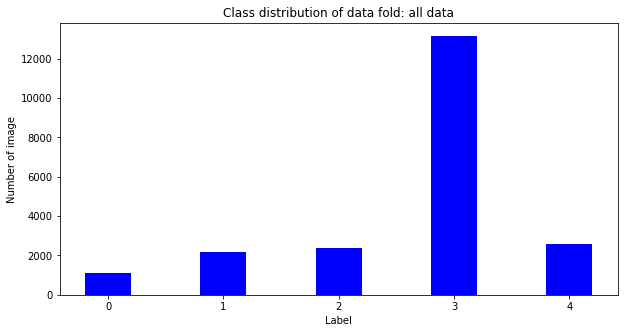

label
0     466
1    1443
2     773
3    2658
4     316
Name: image_id, dtype: int64


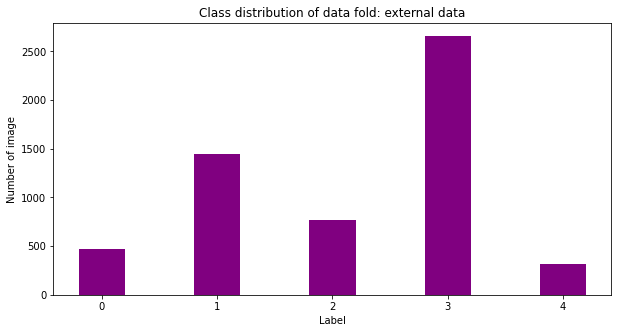

label
0     1335
1     3194
2     2682
3    13185
4     2377
Name: image_id, dtype: int64


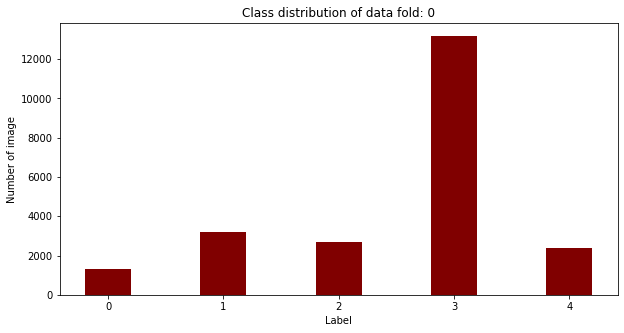

In [482]:
def visualize_class_dis(df, fold, color='maroon'):
    x = df.groupby('label').count()
    print(x['image_id'])
    y = [0,1,2,3,4]

    fig = plt.figure(figsize=(10,5))
    plt.bar(y, x['image_id'].values, color =color, width = 0.4)
    plt.xlabel("Label") 
    plt.ylabel("Number of image") 
    plt.title(f"Class distribution of data fold: {fold}") 

    # plt.xticks(x['image_id'])
    plt.show()
visualize_class_dis(train, 'all data', color='blue')
visualize_class_dis(train_external, 'external data', color='purple')
visualize_class_dis(train_folds, params['fold'])

In [483]:
# Dataset
class TrainDataset(Dataset):
    def __init__(self, df, transform=None, mosaic_mix = False):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        self.mosaic_mix = mosaic_mix
        self.rand_aug_fn = RandAugment()
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{root}/train_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = torch.tensor(self.labels[idx]).long()
        if params["rand_aug"]:
            image = np.array(self.rand_aug_fn(Image.fromarray(image)))
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label, file_name
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{root}/train_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

### Use Albumentations to define transformation functions for the train and validation datasets

In [484]:
train_transform = A.Compose(
    [
        A.RandomResizedCrop(height=params["image_size"], width=params["image_size"], p=1),
#         A.RandomCrop(width=128,height=128, p=1.),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.IAAAffine(rotate=0.2, shear=0.2,p=0.5),
        A.CoarseDropout(max_holes=20, max_height=10, max_width=10, p=0.5),
        A.HueSaturationValue(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_transform = A.Compose(
    [
        A.Resize(params["image_size"],params["image_size"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_transform = transforms.Compose(
    [
     transforms.FiveCrop(params["image_size"]), # this is a list of PIL Images
     transforms.Lambda(lambda crops: torch.stack([ToTensorV2()(crop) for crop in crops])),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),   
        
    ]
)
mixup_fn = Mixup(mixup_alpha=1., cutmix_alpha=1, label_smoothing=0.1, num_classes=params["num_classes"])

train_dataset = TrainDataset(train_folds, transform=train_transform)
val_dataset = TrainDataset(val_folds, transform=val_transform)
test_dataset = TrainDataset(val_folds, transform=test_transform)

Also let's define a function that takes a dataset and visualizes different augmentations applied to the same image.

In [485]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

In [486]:
if params["visualize"]:
    random.seed(SEED)
    visualize_augmentations(train_dataset, idx=3)

In [487]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [488]:
# Visualize Mixup CutMix Aug
def visualize_mix_augmentations(dataset, idx=[1,2,3,4], cols=4):
    dataset = copy.deepcopy(dataset)
    rows = 1
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))
    images = []
    labels = []
    for i in idx:
        image, label, _ = dataset[i]
        images.append(image)
        labels.append(label)
        
    images, labels = mixup_fn(torch.stack(images).cuda(), torch.stack(labels).float().cuda())
    for i, (image,label) in enumerate(zip(images, labels)):
        unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        image = (unorm(image).cpu().numpy()*255).astype(int)
        ax.ravel()[i].imshow(image.transpose(1,2,0))
        ax.ravel()[i].set_title(label.argmax(), color='GREEN')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()  

In [489]:
if params["visualize"]:
    random.seed(SEED)
    visualize_mix_augmentations(train_dataset)

### Define helpers for training

We define a few helpers for our training pipeline. `calculate_accuracy` takes model predictions and true labels and will return accuracy for those predictions. `MetricMonitor` helps to track metrics such as accuracy or loss during training and validation

In [490]:
def calculate_accuracy(output, target):
    output = torch.argmax(torch.softmax(output, dim=1), dim=1)
#     return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
    if params["mix_up"]:
        return accuracy_score(output.cpu(), target.argmax(1).cpu())
    
    output = torch.softmax(output, dim = 1)
    return accuracy_score(output.argmax(1).cpu(), target.cpu())

In [491]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()
        self.curr_acc = 0.
    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]
        self.curr_acc = metric["avg"]
    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [492]:
if params["hard_negative_sample"]:
    train_loader = DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=params["num_workers"], pin_memory=True,
    )
else:
    train_loader = DataLoader(
        train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
    )
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [493]:
def update_hard_sample(train_loader, model, val_criterion, thres):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    train_loss_list = {'image_id':[],
                       'label':[],
                       'loss':[],
                       'fold':[]}
    model.eval()
    stream = tqdm(train_loader)
    with torch.no_grad():
        for i, (images, target, name) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)#.view(-1,params['batch_size'])
            output = model(images)
            loss = val_criterion(output, target)
            if loss > thres:
                train_loss_list['image_id'].append(name[0])
                train_loss_list['label'].append(int(target[0].cpu().numpy()))
                train_loss_list['loss'].append(loss)
                train_loss_list['fold'].append(params['fold'])
    print("Number hard samples:",len(train_loss_list["loss"]))
    #visualize
    ax.ravel()[0].plot(train_loss_list['loss'])
    ax.ravel()[0].set_title("Loss", color='BLUE')
    #ax.ravel()[0].set_axis_off() 
    
    ax.ravel()[1].plot(sorted(train_loss_list['loss']))
    ax.ravel()[1].set_title("Sort Curve", color='BLUE')
    #ax.ravel()[1].set_axis_off() 
    plt.tight_layout()
    plt.show()  
        
    return dict(image_id=train_loss_list['image_id'],
                label=train_loss_list['label'],
                fold=train_loss_list['fold'])

### Define training parameters 

Here we define a few training parameters such as model architecture, learning rate, batch size, epochs, etc

In [494]:
model = timm.create_model(
        params["model"],
        pretrained=True,
        num_classes=params["num_classes"],
        drop_block_rate=params["drop_block"],
        drop_rate=params["drop"]) 

### Create all required objects and functions for training and validation

  0%|          | 0/22773 [00:00<?, ?it/s]

Load pretrained model:  0.8867


100%|██████████| 22773/22773 [02:52<00:00, 132.32it/s]


Number hard samples: 14809


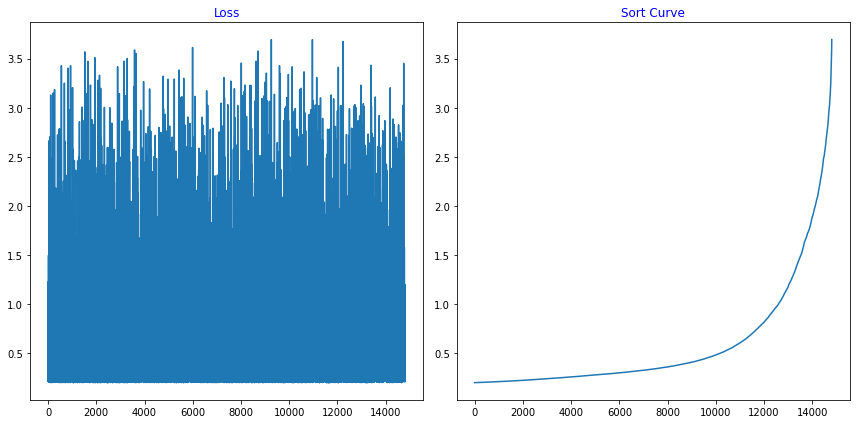

Class distribution for the new data
label
0    1174
1    2977
2    2666
3    5746
4    2246
Name: image_id, dtype: int64


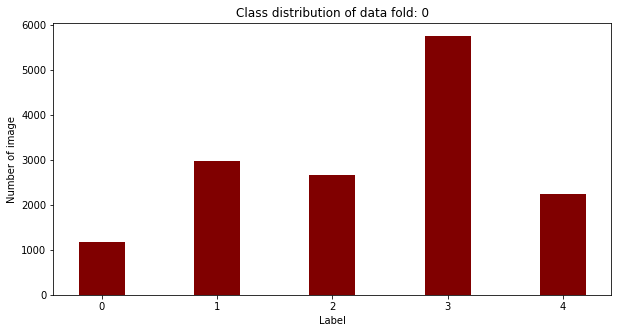

In [495]:
# model = getattr(models, params["model"])(pretrained=False, num_classes=5)
model = model.to(params["device"])

if params["distributed"]:
    assert ValueError("No need to implement in a single machine")
else:
    model = torch.nn.DataParallel(model)    
if params["load_pretrained"]:
    state_dict = torch.load("weights/resnest26d_fold0_best_epoch_21_final_external.pth")
    print("Load pretrained model: ",state_dict["preds"])
    model.load_state_dict(state_dict["model"])
    best_acc = state_dict["preds"]
    # Hard negative mining based on train data and pretrained model on that data
    if params["hard_negative_sample"]:
        update_train_data = update_hard_sample(train_loader, model, val_criterion, thres=0.2)
        update_train_folds = pd.DataFrame(data=update_train_data)
        
        #check the update distribution when filter data
        print("Class distribution for the new data")
        visualize_class_dis(update_train_folds, params["fold"])
        
        #update the training set
        update_train_dataset = TrainDataset(update_train_folds, transform=train_transform)
        update_train_loader = DataLoader(
            update_train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
        )                
else:
    best_acc = 0.
    
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"])
# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=params["lr_min"], last_epoch=-1)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=params["lr_min"], last_epoch=-1)

val_criterion = nn.CrossEntropyLoss().to(params["device"])
# criterion = nn.CrossEntropyLoss().to(params["device"])
criterion = LabelSmoothingCrossEntropy().to(params["device"])
if params["mix_up"]:
    criterion = SoftTargetCrossEntropy().to(params["device"])

In [496]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    if params["hard_negative_sample"]:
        stream = tqdm(update_train_loader)
    else:
        stream = tqdm(train_loader)
    for i, (images, target, _) in enumerate(stream, start=1):
        images = images.to(params["device"]) #, non_blocking=True)
        target = target.to(params["device"]) #, non_blocking=True) #.view(-1,params['batch_size'])
        if params["mix_up"]:
            images , target = mixup_fn(images, target)
        output = model(images)
        if isinstance(output, (tuple, list)):
            output = output[0]
        loss = criterion(output, target)
        if params['gradient_accumulation_steps'] > 1:
            loss = loss / params['gradient_accumulation_steps']
    
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [497]:
def validate(val_loader, model, criterion, epoch, params, fold, best_acc):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)#.view(-1,params['batch_size'])
            output = model(images)
            loss = val_criterion(output, target)
            
            output = torch.softmax(output, dim = 1)
            accuracy = accuracy_score(output.argmax(1).cpu(), target.cpu())

            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )           
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
        #to save weight
        if (metric_monitor.curr_acc > best_acc): # or epoch == params["epochs"]:
            print(f"Save best weight at acc {round(metric_monitor.curr_acc,4)}, epoch: {epoch}")
            torch.save({'model': model.state_dict(), 
                'preds': round(metric_monitor.curr_acc,4)},
                 f'weights/{params["model"]}_fold{fold}_best_epoch_{epoch}.pth')

            best_acc = metric_monitor.curr_acc
    return best_acc

In [498]:
def tta_predict(val_loader, model, criterion, epoch, params, fold, best_acc):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)#.view(-1,params['batch_size'])
            output = model(images)
            loss = val_criterion(output, target)
            
            output = torch.softmax(output, dim = 1)
            accuracy = accuracy_score(output.argmax(1).cpu(), target.cpu())
            
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

    return best_acc

### Train a model

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    best_acc = validate(val_loader, model, criterion, epoch, params, fold, best_acc)

Epoch: 1. Train.      Loss: 1.090 | Accuracy: 0.724:  76%|███████▌  | 703/926 [03:42<01:10,  3.17it/s]

### Predict labels for images and visualize those predictions

In [ ]:
# torch.save({'model': model.state_dict(), 
#                     'preds': 0.881},
#                      f'weights/{params["model"]}_fold{fold}_best_epoch_{epoch}_final.pth')

Now we have a trained model, so let's try to predict labels for some images and see whether those predictions are correct. First we make the `CatsVsDogsInferenceDataset` PyTorch dataset. Its code is similar to the training and validation datasets, but the inference dataset returns only an image and not an associated label (because in the real world we usually don't have access to the true labels and want to infer them using our trained model).

In [ ]:
# model = model.eval()
# predicted_labels = []
# with torch.no_grad():
#     for images in test_loader:
#         images = images.to(params["device"], non_blocking=True)
#         output = model(images)

As we see our model predicted correct labels for 7 out of 10 images. If you train the model for more epochs, you will obtain better results.